In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import os

# os.environ["JAX_PLATFORM_NAME"] = "cpu"

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_enable_x64", True)

jax.devices()

[CudaDevice(id=0)]

In [3]:
type(np.ceil(5./2).astype(int)), np.ceil(5./2).astype(int)

(numpy.int64, 3)

In [4]:
from ernestogym.envs_jax.single_agent.utils import parameter_generator

In [5]:
pack_options = "ernestogym/ernesto_jax/data/battery/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery/models/aging/bolun_pack_dropflow.yaml"
world = "ernestogym/envs_jax/single_agent/world_deg.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params

{'battery': {'sign_convention': 'passive',
  'params': {'nominal_voltage': 350.4,
   'nominal_capacity': 60.0,
   'nominal_dod': 0.8,
   'nominal_lifetime': 3000,
   'v_max': 398.4,
   'v_min': 288.0,
   'temp_ambient': 298.15,
   'nominal_cost': 3000.0},
  'bounds': {'voltage': {'low': 288.0, 'high': 398.4},
   'current': {'low': -180.0, 'high': 60.0},
   'power': {'low': -71712.0, 'high': 23904.0},
   'temperature': {'low': 273.15, 'high': 323.15},
   'temp_ambient': {'low': 273.15, 'high': 313.15},
   'soc': {'low': 0.2, 'high': 0.8},
   'soh': {'low': 0.8, 'high': 1.0}},
  'init': {'voltage': 288.0,
   'current': 0.0,
   'power': 0.0,
   'temperature': 293.15,
   'temp_ambient': 293.15,
   'soc': 0.5,
   'soh': 1.0}},
 'input_var': 'current',
 'models_config': [{'type': 'electrical',
   'class_name': 'TheveninModel',
   'use_fading': False,
   'components': {'r0': {'selected_type': 'scalar',
     'scalar': 10.0,
     'lookup': {'table': 'r0_pack.csv',
      'inputs': [{'var': 'temp

In [6]:
key = jax.random.key(30)

In [7]:
from ernestogym.envs_jax.single_agent.env import MicroGridEnv as JaxEnv

In [8]:
def prep_for_training(params, battery_type, demand_profile):
    env = JaxEnv(params, battery_type, demand_profile)

    initial_state = env.initial_state
    env_params = env.params

    return env, initial_state, env_params

In [9]:
env_jax, initial_state, env_params = prep_for_training(params, battery_type=battery_type, demand_profile='64')

In [10]:
initial_state

EnvState(time=Array(0, dtype=int32, weak_type=True), battery_state=BessBolunDropflowState(nominal_capacity=Array(60., dtype=float32, weak_type=True), nominal_cost=Array(3000., dtype=float32, weak_type=True), nominal_voltage=Array(350.4, dtype=float32, weak_type=True), nominal_dod=Array(0.8, dtype=float32, weak_type=True), nominal_lifetime=Array(3000, dtype=int32, weak_type=True), c_max=Array(60., dtype=float32, weak_type=True), temp_ambient=Array(293.15, dtype=float32, weak_type=True), v_max=Array(398.4, dtype=float32, weak_type=True), v_min=Array(288., dtype=float32, weak_type=True), elapsed_time=Array(0., dtype=float32, weak_type=True), electrical_state=ElectricalModelState(r0_nominal=Array(10., dtype=float32, weak_type=True), r0=Array(10., dtype=float32, weak_type=True), rc=RCState(resistance_nominal=Array(10., dtype=float32, weak_type=True), resistance=Array(10., dtype=float32, weak_type=True), capacity=Array(10., dtype=float32, weak_type=True), i_resistance=Array(0., dtype=float32

In [11]:
def train(env:JaxEnv, env_params):

    def policy(obs, key):
        # return jax.random.uniform(key, minval=env_params.i_min_action, maxval=env_params.i_max_action)
        return jax.random.uniform(key, minval=-50, maxval=50)

    def iter_body(i, val):
        state, obs, key, log = val
        key, subkey1, subkey2 = jax.random.split(key, 3)

        a = policy(obs, key)

        obs, state, reward, done, info = env.step_env(subkey2, state, a, env_params)    #FIXME è step non step_env

        def update_dict(d, r_trad, r_op, r_deg, r_clipping):
            d['r_trad'] = d['r_trad'].at[i].set(r_trad)
            d['r_op'] = d['r_op'].at[i].set(r_op)
            d['r_deg'] = d['r_deg'].at[i].set(r_deg)
            d['r_clip'] = d['r_clip'].at[i].set(r_clipping)

        log['soc'] = log['soc'].at[i].set(info['soc'])
        log['soh'] = log['soh'].at[i].set(info['soh'])

        update_dict(log['pure_reward'], **info['pure_reward'])
        update_dict(log['norm_reward'], **info['norm_reward'])
        update_dict(log['weig_reward'], **info['weig_reward'])
        log['r_tot'] = log['r_tot'].at[i].set(info['r_tot'])

        log['action'] = log['action'].at[i].set(a)

        return state, obs, key, log

    def training_loop(num_iter, init_key):

        log = {'soc': jnp.zeros(num_iter),
               'soh': jnp.zeros(num_iter),
               'pure_reward': {'r_trad': jnp.zeros(num_iter),
                               'r_op': jnp.zeros(num_iter),
                               'r_deg': jnp.zeros(num_iter),
                               'r_clip': jnp.zeros(num_iter)},
               'norm_reward': {'r_trad': jnp.zeros(num_iter),
                               'r_op': jnp.zeros(num_iter),
                               'r_deg': jnp.zeros(num_iter),
                               'r_clip': jnp.zeros(num_iter)},
               'weig_reward': {'r_trad': jnp.zeros(num_iter),
                               'r_op': jnp.zeros(num_iter),
                               'r_deg': jnp.zeros(num_iter),
                               'r_clip': jnp.zeros(num_iter)},
               'r_tot': jnp.zeros(num_iter),
               'action': jnp.zeros(num_iter)}

        key, subkey = jax.random.split(init_key)

        obs, initial_state = env.reset(subkey, env_params)

        state, obs, key, log = jax.lax.fori_loop(0,num_iter, iter_body, (initial_state, obs, key, log))
        return state, log

    return jax.jit(training_loop, static_argnums=(0,))

In [12]:
jitted_training_loop = train(env_jax, env_params)

In [13]:
from time import time

num_iter = 10001

t1 = time()

state, log = jitted_training_loop(num_iter, key)

print(time() - t1)

log = jax.tree.map(lambda x: np.array(x), log)
log

2.5901060104370117


{'action': array([ 49.53675  ,  45.11374  , -13.8160095, ...,   5.6184425,
        -26.501633 , -29.939043 ], dtype=float32),
 'norm_reward': {'r_clip': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'r_deg': array([ -0.      ,  -0.      ,  -0.      , ...,  -0.      ,  -0.      ,
         -16.617626], dtype=float32),
  'r_op': array([-7.5464980e-03, -7.4769803e-03, -4.2846060e-09, ...,
         -8.7569706e-06, -7.1004702e-04, -1.2499818e-03], dtype=float32),
  'r_trad': array([-1.2976252 , -2.8131542 ,  0.3450306 , ...,  0.13674174,
         -0.19883756, -1.2698517 ], dtype=float32)},
 'pure_reward': {'r_clip': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'r_deg': array([ -0.      ,  -0.      ,  -0.      , ...,  -0.      ,  -0.      ,
         -16.617626], dtype=float32),
  'r_op': array([-2.2639494e+01, -2.2430941e+01, -1.2853819e-05, ...,
         -2.6270913e-02, -2.1301410e+00, -3.7499456e+00], dtype=float32),
  'r_trad': array([-0.2040801 , -0.4424304 ,  0.0542636

Text(0.5, 1.0, 'r deg')

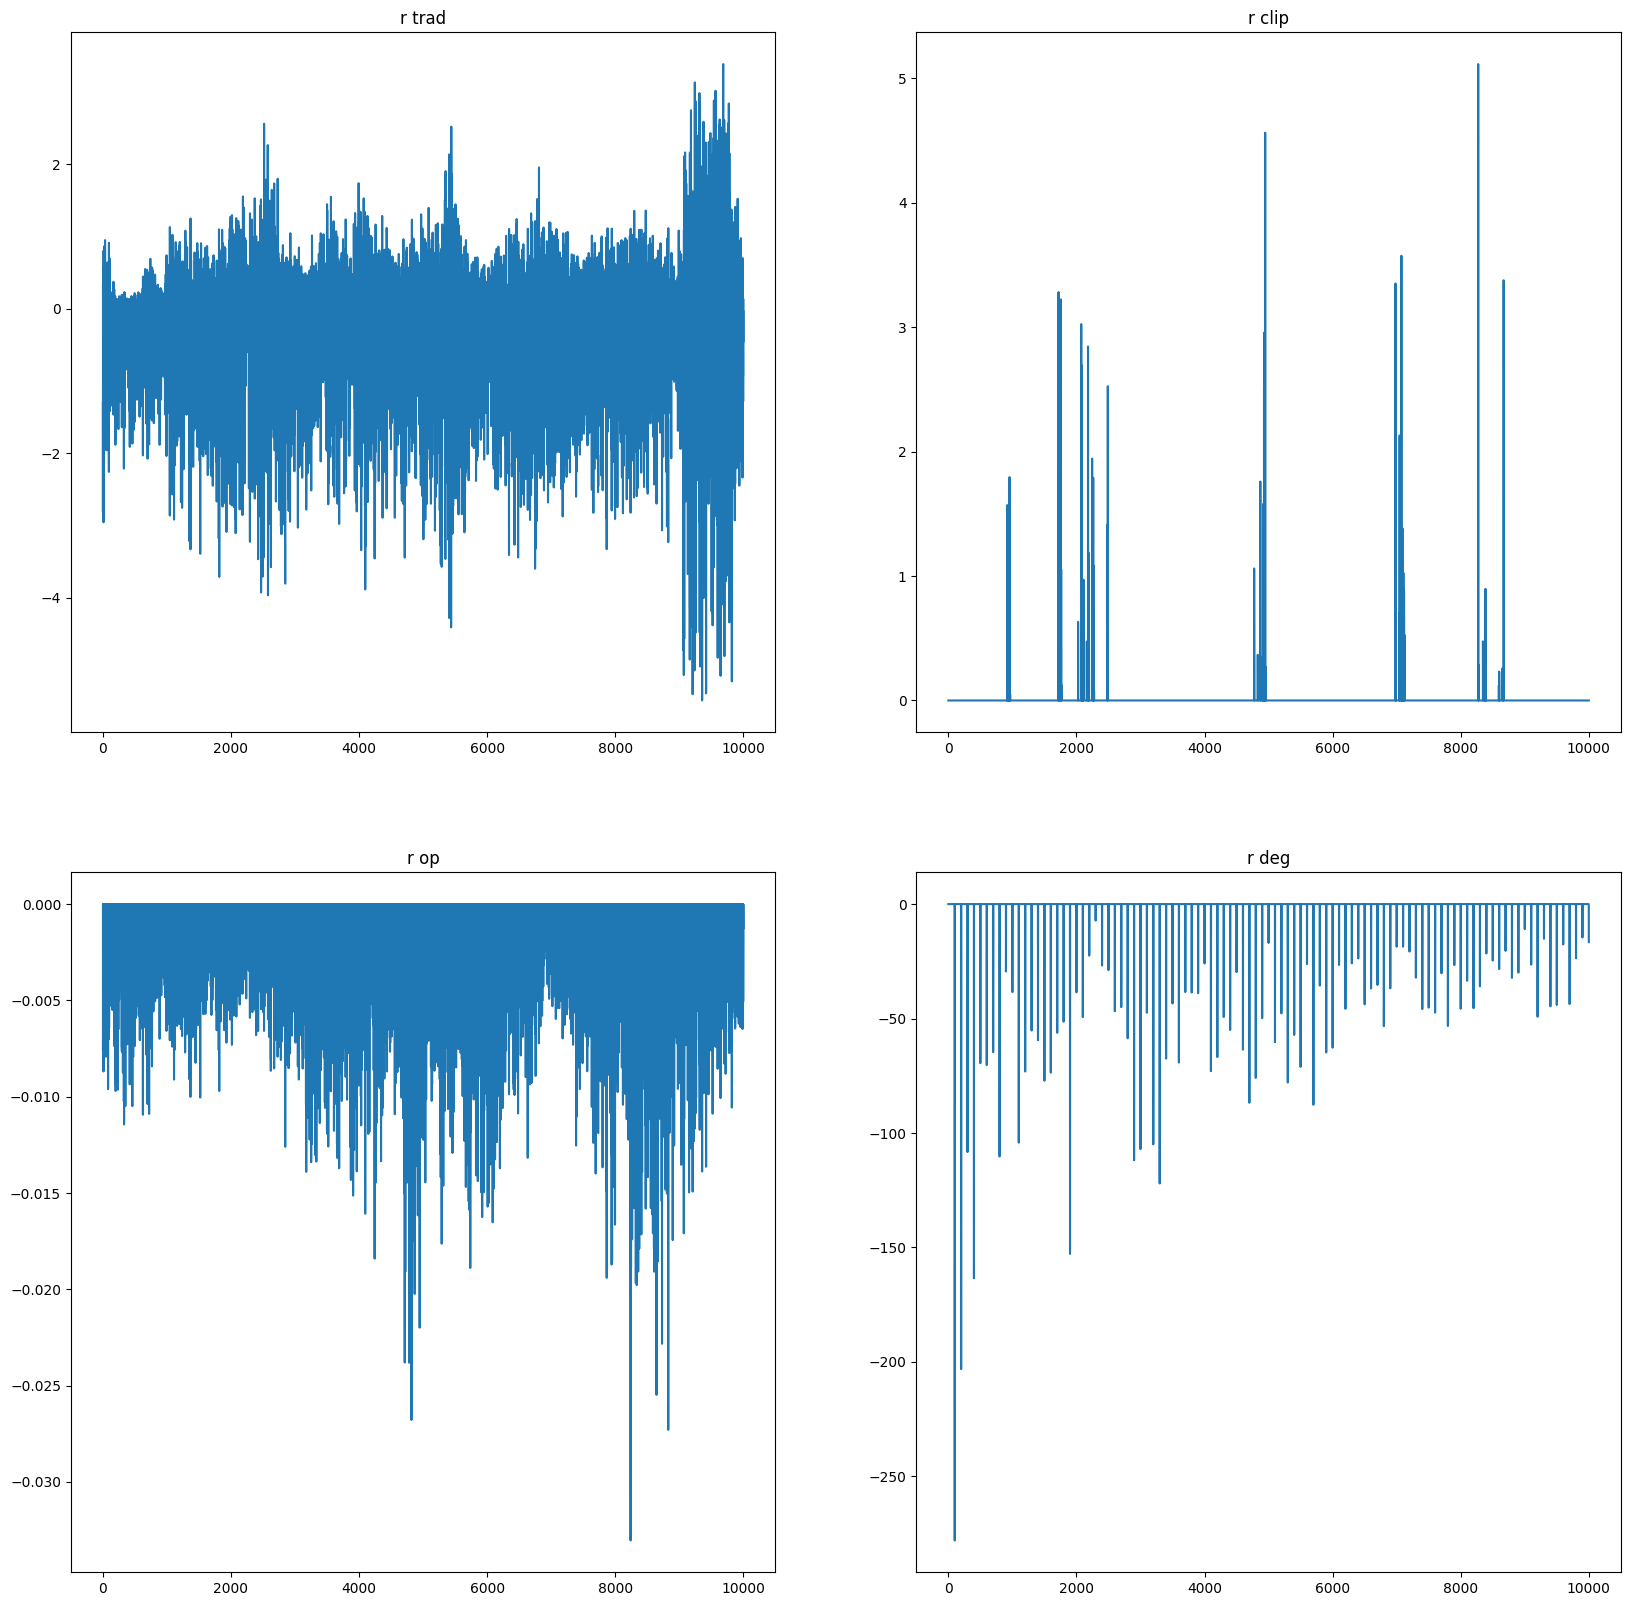

In [18]:
reward_type = 'weig_reward'

f = plt.figure(figsize=(20, 20))

a1 = f.add_subplot(2, 2, 1)
a1.plot(log[reward_type]['r_trad'])
a1.set_title('r trad')

a2 = f.add_subplot(2, 2, 2)
a2.plot(log[reward_type]['r_clip'])
a2.set_title('r clip')

a3 = f.add_subplot(2, 2, 3)
a3.plot(log[reward_type]['r_op'])
a3.set_title('r op')

a4 = f.add_subplot(2, 2, 4)
a4.plot(log[reward_type]['r_deg'])
a4.set_title('r deg')

Text(0.5, 1.0, 'soh')

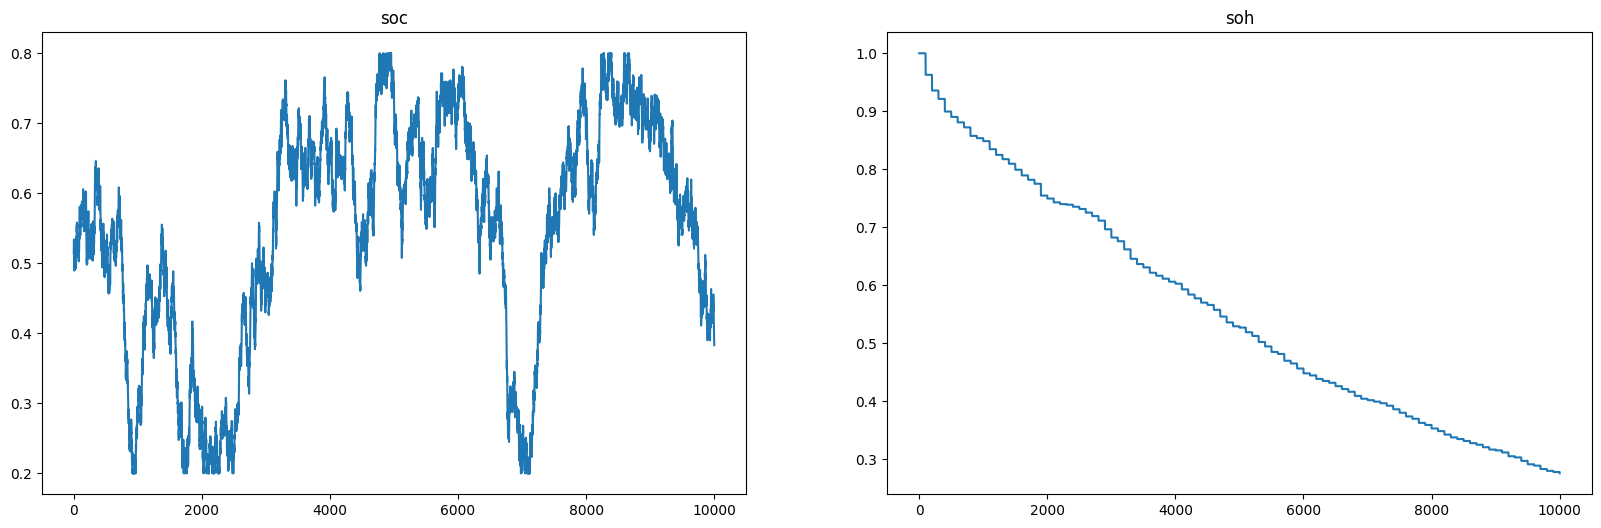

In [17]:
f = plt.figure(figsize=(20, 6))

a1 = f.add_subplot(1, 2, 1)
a1.plot(log['soc'])
a1.set_title('soc')

a2 = f.add_subplot(1, 2, 2)
a2.plot(log['soh'])
a2.set_title('soh')